# Data handling and cleaning

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# global variables
DATA_PATH = r"../data/yellow_tripdata_2020-01.csv"
SHP_INPUT_PATH = r"../data/taxi_zones/taxi_zones.shp"
COLUMNS_TO_DROP = [
    'VendorID',
    'RatecodeID',
    'store_and_fwd_flag',
    'payment_type',
    'fare_amount',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount',
    'improvement_surcharge', 
    'congestion_surcharge'
]

In [81]:
# important: all functions assume, in some manner, the dataset's data structure
# scripts do João Arthur
def read_data(path=None):
    """
    Reads the input CSV data to a dataframe.
    :path: (str) path to a custom data source.
    :return: (pandas.DataFrame) all input data.
    """
    return pd.read_csv(path or DATA_PATH)

def format_date_column(df, col, col_dow, col_hour, col_period):
    """
    Formats timestamp column to date and type columns.
    :param df: (pandas.DataFrame) dataset to have its timestamp column expanded to date and time columns.
    :param col: (str) column name containing timestamp data.
    :param col_dow: (str) column name for newly added day of the week column.
    :param col_hour: (str) column name for newly added hour column.
    :param col_period: (str) column name for newly added hour period of the day.
    :return: (pandas.DataFrame) dataset with date and time columns.
    """
    to_datetime_col = pd.to_datetime(df[col]).dt
    df[col_dow] = to_datetime_col.day_name()
    df[col_hour] = to_datetime_col.hour
    df[col_period] = pd.cut(
        to_datetime_col.hour,
        bins=[-.1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
        labels=["0-2", "2-4", "4-8", "8-10", "10-12", "12-14", "14-16", "16-18", "18-20", "20-22", "22-24"]
    )
    return df

def setup_data(df, columns_to_drop=None):
    """
    Reads the input CSV data to a dataframe.
    :param df: (pandas.DataFrame) dataset to be cleaned.
    :param columns_to_drop: (list-of-str) list of columns to be dropped.
    :return: (pandas.DataFrame) cleaned up dataset.
    """
    df = df.drop(columns_to_drop or COLUMNS_TO_DROP, axis=1)
    df = format_date_column(df, "tpep_pickup_datetime", "PU_Dow", "PU_Hour", "PU_Period")
#     df = format_date_column(df, "tpep_dropoff_datetime", "DO_Date", "DO_Time")
    # missing duration - still to do
    df["target"] = df["total_amount"] / df["trip_distance"]
    return df

def read_shape(path=None):
    """
    Reads the shapefile containing localtion polygons.
    :return: (geopandas.GeoDataFrame) data frame for the location shapefile data.
    """
    return gpd.read_file(path or SHP_INPUT_PATH)


In [86]:
df = read_data()
df1 = df[1000:].reset_index()
df1 = setup_data(df1)

/Users/Joao/Desktop/FGV/Aplicações de Estatística Espacial/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


<AxesSubplot:>

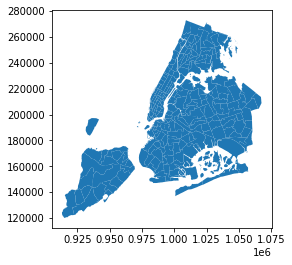

In [34]:
shp = read_shape()
shp = shp.drop(["Shape_Leng", "Shape_Area"], axis=1).set_index("OBJECTID")
shp.plot()

/Users/Joao/Desktop/FGV/Aplicações de Estatística Espacial/venv/lib/python3.6/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/Joao/Desktop/FGV/Aplicações de Estatística Espacial/venv/lib/python3.6/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/Joao/Desktop/FGV/Aplicações de Estatística Espacial/venv/lib/python3.6/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/Joao/Desktop/FGV/Aplicações de Estatística Espacial/venv/lib/python3.6/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/Joao/Desktop/FGV/Aplicações de Estatística Espacial/venv/lib/python3.6/site-packages/numpy/core/_methods.py:1

<AxesSubplot:xlabel='PU_Dow', ylabel='target'>

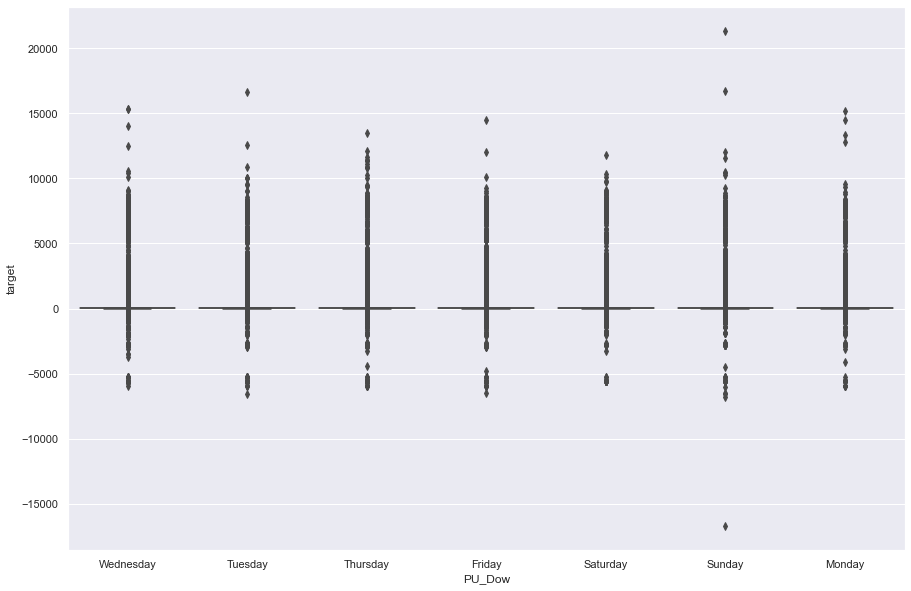

In [88]:
sns.set(rc={'figure.figsize': (15, 10)})
sns.boxplot(data=df1, x="PU_Dow", y="target")

In [89]:
df1.dropna().groupby(["PU_Period", "PU_Dow",'PULocationID']).target.mean().reset_index()

,PU_Period,PU_Dow,PULocationID,target
0,0-2,Friday,1,inf
1,0-2,Friday,2,NaN
2,0-2,Friday,3,NaN
3,0-2,Friday,4,inf
4,0-2,Friday,5,3.407917
...,...,...,...,...
20015,22-24,Wednesday,261,inf
20016,22-24,Wednesday,262,inf
20017,22-24,Wednesday,263,NaN
20018,22-24,Wednesday,264,inf


In [21]:
outshp = shp.merge(df1, left_on="LocationID", right_on="PULocationID", how="left")

In [ ]:
['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry', 'index', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'total_amount', 'PU_Dow', 'PU_Hour', 'PU_Period']